In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2")
%matplotlib inline

import category_encoders as ce

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
RANDOM_STATE = 2

## Разведывательный анализ данных

In [77]:
# загружаем данные
data = pd.read_csv('data/data.csv')
data.head(3)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350


In [78]:
# переводим названяи столбцов в нижний регистр и меняем пробелы на _
data.columns = data.columns.str.lower().str.replace(' ', '_')

# собираем список строковых столбцов
string_col = list(data.dtypes[data.dtypes == 'object'].index)

# в столбцах понижаем регистр, меняем пробелы на _
for col in string_col:
    data[col] = data[col].str.lower().str.replace(' ', '_')

data.head(3)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(3), int64(5

### Анализ целевой переменной

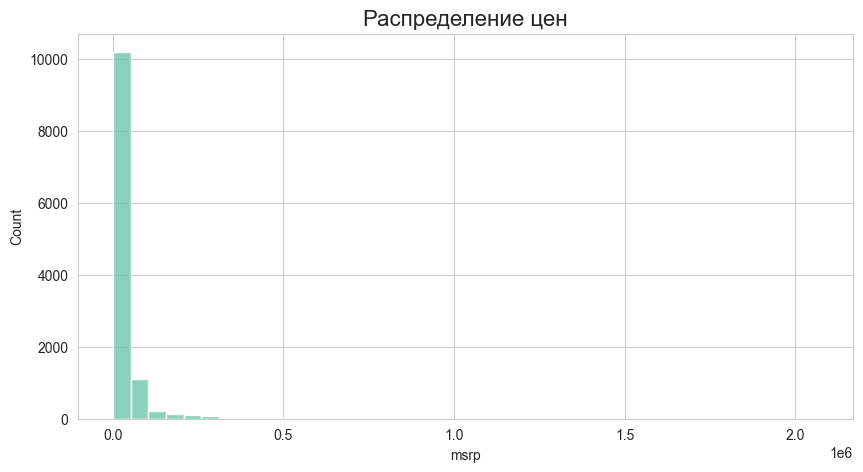

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data['msrp'], bins=40)
ax.set_title('Распределение цен',fontsize=16)
plt.show()

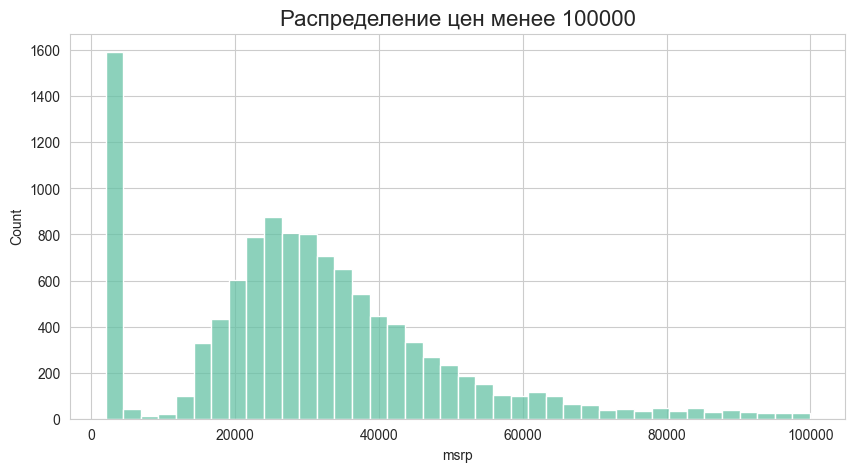

In [81]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data['msrp'][data['msrp'] < 100000], bins=40)
ax.set_title('Распределение цен менее 100000',fontsize=16)
plt.show()

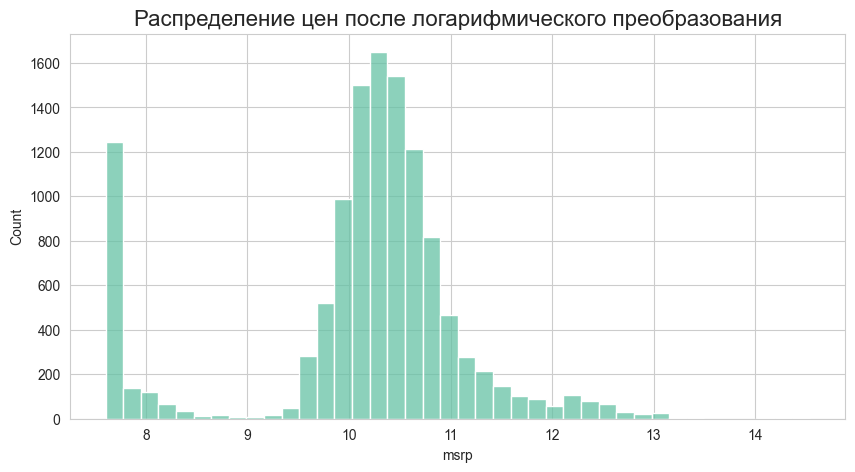

In [82]:
log_prise = np.log1p(data['msrp'])
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(log_prise, bins=40)
ax.set_title('Распределение цен после логарифмического преобразования',fontsize=16)
plt.show()

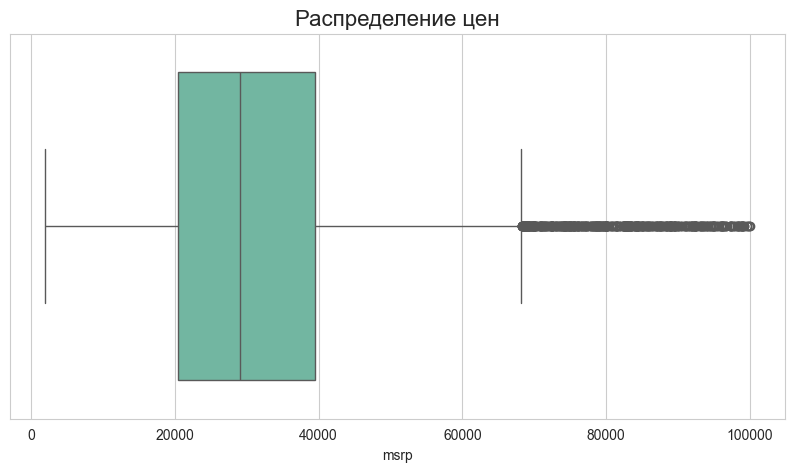

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data['msrp'][data['msrp'] < 100000], orient='h')
ax.set_title('Распределение цен',fontsize=16)
plt.show()

Целевая переменная не распрелелена нормально, возможно оправдано применение логарифмической функции, работа с выбросами

### Проверка на дубликаты

In [84]:
print(f"Всего дубликатов: {data.duplicated().sum()}\n{data.shape}")

Всего дубликатов: 715
(11914, 16)


In [85]:
data = data.drop_duplicates()
print(f"Всего дубликатов: {data.duplicated().sum()}\n{data.shape}")

Всего дубликатов: 0
(11199, 16)


### Проверка на пропуски

In [86]:
data.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3376
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

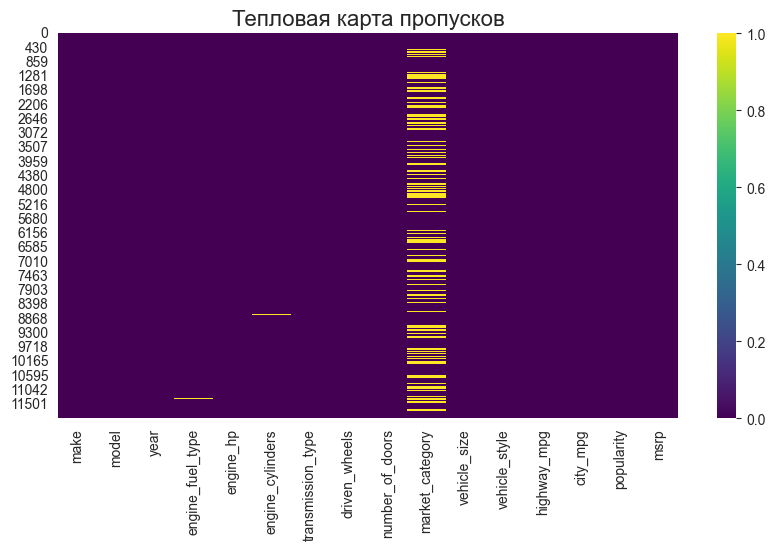

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(data.isna(), cmap='viridis')
ax.set_title('Тепловая карта пропусков',fontsize=16)
plt.show()

Присутсвтуют пропуски в поризнаках market_category, engine_fuel_type, engine_hp, engine_cylinders:

Возможные варианты решения:
* engine_fuel_type заполянем 'regular_unleaded'
* engine_hp заполняем средним
* engine_cylinders электрическим машинам заполняем как 0.0, остальным по моде
* market_category можно разделить на нескольк опризнаков, пропуски заполнить 0
* number_of_doors coupe заполянем 2.0, sedan заполдняем 4.0

### Анализ признаков

#### Тип object 

In [88]:
data.select_dtypes(include=['object']).columns

Index(['make', 'model', 'engine_fuel_type', 'transmission_type',
       'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style'],
      dtype='object')

In [89]:
# make
data['make'].value_counts().count()

# Binary

48

In [90]:
# model
data['model'].value_counts().count()

# Binary

914

In [91]:
# engine_fuel_type
data['engine_fuel_type'].unique()

# сгрупперуем в группы: regular_unleaded premium_unleaded diesel electric flex-fuel и unknown

array(['premium_unleaded_(required)', 'regular_unleaded',
       'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)',
       'diesel', 'electric',
       'flex-fuel_(premium_unleaded_recommended/e85)', 'natural_gas',
       'flex-fuel_(premium_unleaded_required/e85)',
       'flex-fuel_(unleaded/natural_gas)', nan], dtype=object)

In [92]:
# transmission_type
data['transmission_type'].value_counts()

# OneHot

automatic           7932
manual              2634
automated_manual     553
direct_drive          68
unknown               12
Name: transmission_type, dtype: int64

In [93]:
# driven_wheels
data['driven_wheels'].value_counts()

# OneHot

front_wheel_drive    4354
rear_wheel_drive     3212
all_wheel_drive      2308
four_wheel_drive     1325
Name: driven_wheels, dtype: int64

In [94]:
# market_category
data['market_category'].value_counts()

# Binary

crossover                                          1075
flex_fuel                                           855
luxury                                              819
luxury,performance                                  659
hatchback                                           574
                                                   ... 
crossover,exotic,luxury,performance                   1
exotic,luxury,high-performance,hybrid                 1
crossover,exotic,luxury,high-performance              1
flex_fuel,factory_tuner,luxury,high-performance       1
performance,hybrid                                    1
Name: market_category, Length: 71, dtype: int64

In [95]:
# vehicle_size
data['vehicle_size'].value_counts()

# Порядковый

compact    4395
midsize    4121
large      2683
Name: vehicle_size, dtype: int64

In [96]:
# vehicle_style
data['vehicle_style'].value_counts()

# OneHot

sedan                  2843
4dr_suv                2434
coupe                  1175
convertible             741
4dr_hatchback           663
crew_cab_pickup         655
extended_cab_pickup     597
wagon                   562
2dr_hatchback           412
passenger_minivan       389
regular_cab_pickup      345
passenger_van           121
2dr_suv                  91
cargo_van                84
cargo_minivan            59
convertible_suv          28
Name: vehicle_style, dtype: int64

#### Числовой тип

In [97]:
data.select_dtypes(exclude=['object']).columns

Index(['year', 'engine_hp', 'engine_cylinders', 'number_of_doors',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

In [98]:
data['engine_cylinders'].value_counts()

# OneHot

4.0     4362
6.0     4291
8.0     1965
12.0     228
5.0      169
10.0      65
0.0       56
3.0       30
16.0       3
Name: engine_cylinders, dtype: int64

In [99]:
#number_of_doors
data['number_of_doors'].value_counts()

# OneHot

4.0    7960
2.0    2877
3.0     356
Name: number_of_doors, dtype: int64

### Подготовка данных

In [ ]:
# обработка пропусков
def nun_prepare(df):

    df['engine_fuel_type'] = df['engine_fuel_type'].fillna('regular_unleaded')

    engine_hp_mean = data['engine_hp'].mean()
    df['engine_hp'] = df['engine_hp'].fillna(engine_hp_mean)

    engine_cylinders_mode = data['engine_cylinders'].mode()[0]
    engine_cylinders_mapping = {'electric': 0.0}
    df['engine_cylinders'] = df['engine_cylinders'].fillna(df['engine_fuel_type'].map(engine_cylinders_mapping))
    df['engine_cylinders'] = df['engine_cylinders'].fillna(engine_cylinders_mode)

    door_mapping = {'coupe': 2.0, 'sedan': 4.0}
    df['number_of_doors'] = df['number_of_doors'].fillna(df['vehicle_style'].map(door_mapping))

    df['market_category'] = df['market_category'].fillna(0)

    return df

"# обработка пропусков\ndef nun_prepare(df):\n\n    df['engine_fuel_type'] = df['engine_fuel_type'].fillna('regular_unleaded')\n\n    engine_hp_mean = df['engine_hp'].mean()\n    df['engine_hp'] = df['engine_hp'].fillna(engine_hp_mean)\n\n    engine_cylinders_mode = df['engine_cylinders'].mode()[0]\n    engine_cylinders_mapping = {'electric': 0.0}\n    df['engine_cylinders'] = df['engine_cylinders'].fillna(df['engine_fuel_type'].map(engine_cylinders_mapping))\n    df['engine_cylinders'] = df['engine_cylinders'].fillna(engine_cylinders_mode)\n\n    door_mapping = {'coupe': 2.0, 'sedan': 4.0}\n    df['number_of_doors'] = df['number_of_doors'].fillna(df['vehicle_style'].map(door_mapping))\n\n    df['market_category'] = df['market_category'].fillna(0)\n\n    return df"

In [ ]:
# функция создания матрицы X из датафрейма и преобразования признаков
def prepare_x(df):
    ohe_cols = ['engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_style', 'engine_cylinders', 'number_of_doors']
    ori_cols = ['vehicle_size']
    bin_cols = ['make', 'model', 'market_category']

    df_pr = df.copy()

    # кодируем engine_fuel_type
    fuel_groups = {
    'regular_unleaded': 'regular_unleaded',
    'premium_unleaded_(required)': 'premium_unleaded',
    'premium_unleaded_(recommended)': 'premium_unleaded',
    'diesel': 'diesel',
    'electric': 'electric',
    'flex-fuel_(unleaded/e85)': 'flex-fuel',
    'flex-fuel_(premium_unleaded_recommended/e85)': 'flex-fuel',
    'flex-fuel_(premium_unleaded_required/e85)': 'flex-fuel',
    'flex-fuel_(unleaded/natural_gas)': 'flex-fuel'}

    df_pr['engine_fuel_type'] = df_pr['engine_fuel_type'].apply(lambda x: fuel_groups.get(x, 'unknown'))

    # кодируем OneHot
    df_pr = pd.get_dummies(df, columns=ohe_cols, drop_first=True)

    # кодируем порядковые переменные
    encoder_1 = ce.OrdinalEncoder(cols=ori_cols)
    df_pr = encoder_1.fit_transform(df_pr)

    # Кодируем бинарным кодированием
    encoder_2 = ce.BinaryEncoder(cols=bin_cols)
    df_pr = encoder_2.fit_transform(df_pr)


    return df_pr

"# функция создания матрицы X из датафрейма и преобразования признаков\ndef prepare_x(df):\n    ohe_cols = ['engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_style', 'engine_cylinders', 'number_of_doors']\n    ori_cols = ['vehicle_size']\n    bin_cols = ['make', 'model', 'market_category']\n\n    df_pr = df.copy()\n\n    # кодируем engine_fuel_type\n    fuel_groups = {\n    'regular_unleaded': 'regular_unleaded',\n    'premium_unleaded_(required)': 'premium_unleaded',\n    'premium_unleaded_(recommended)': 'premium_unleaded',\n    'diesel': 'diesel',\n    'electric': 'electric',\n    'natural_gas': 'unknown',\n    'flex-fuel_(unleaded/e85)': 'flex-fuel',\n    'flex-fuel_(premium_unleaded_recommended/e85)': 'flex-fuel',\n    'flex-fuel_(premium_unleaded_required/e85)': 'flex-fuel',\n    'flex-fuel_(unleaded/natural_gas)': 'flex-fuel'}\n\n    df_pr['engine_fuel_type'] = df_pr['engine_fuel_type'].apply(lambda x: fuel_groups.get(x, 'unknown'))\n\n    # кодируем OneHot\n   

In [102]:
"""data = nun_prepare(data)
data = prepare_x(data)"""

'data = nun_prepare(data)\ndata = prepare_x(data)'

In [103]:
# разбиваем данные на тренировочные и тестовые
data_train_full, data_test = train_test_split(data, test_size=0.1, random_state=RANDOM_STATE)

# Разбиваем тренировочные данные на тренировочные и валидационные
data_train, data_val = train_test_split(data_train_full, test_size=0.22, random_state=RANDOM_STATE)

# запишем целевую переменную
y_val = np.log1p(data_val['msrp'])
y_test = np.log1p(data_test['msrp'])
y_train = np.log1p(data_train['msrp'])

# удалим целевую переменную из обучающих наборов
del data_val['msrp']
del data_test['msrp']
del data_train['msrp']

In [104]:
# в качестве примера вручную напишем функцию линеной регрессии c регуляризацией
# далее будем использовать моель из бибблиотеки sklearn
#def train_linear_regression(X, y, r=0.0):
#    # добавляем фиктивный столбец
#    ones = np.ones(X.shape[0])
#    X = np.column_stack([ones, X])
#
#    # формула нормлаьного уравнения с регуляризацией
#    XTX = X.T.dot(X)
#    #добавляем к основной диагонали r
#    reg = r * np.eye(XTX.shape[0])
#    XTX = XTX + reg
#
#    XTX_inv = np.linalg.inv(XTX)
#    w = XTX_inv.dot(X.T).dot(y)
#
#    return w[0], w[1:]

### Преобразование признаков 

In [105]:
# выберем признаки на основе которых будем предсказывать цену
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# функция создания матрицы X из датафрейма и преобразования признаков
def prepare_x(df):
    df = df.copy()
    features = base.copy()

    # создадим признак возраста автомобиля(2017 - год создания датасета)
    df['age'] = 2017 - df.year
    features.append('age')

    # кодируем признак кол-ва дверей
    for n in [2, 3, 4]:
        feature = 'number_of_doors%s' % n
        df[feature] = (df['number_of_doors'] == n).astype(int)
        features.append(feature)

    # кодируем признак марки автомобиля
    for m in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % m
        df[feature] = (df['make'] == m).astype(int)
        features.append(feature)

    # кодируем признак типа двигателя
    for t in ['regular_unleaded', 'premium_unleaded_(required)',
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)', 'diesel']:
        feature = 'is_type_%s' % t
        df[feature] = (df['engine_fuel_type'] == t).astype(int)
        features.append(feature)

    # кодируем признак типа трансмиссии
    for tt in ['automatic', 'manual', 'automated_manual', 'direct_drive', 'unknown']:
        feature = 'transmission_type_is_%s' % tt
        df[feature] = (df['transmission_type'] == tt).astype(int)
        features.append(feature)

    # кодируем признак кол-ва ведущих колес
    for dw in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % dw
        df[feature] = (df['driven_wheels'] == dw).astype(int)
        features.append(feature)

    # кодируем признак категории маркетинга
    for mc in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_market_category_%s' % mc
        df[feature] = (df['market_category'] == mc).astype(int)
        features.append(feature)

    # кодируем признак размера
    for s in ['compact', 'midsize', 'large']:
        feature = 'is_vehicle_size_%s' % s
        df[feature] = (df['vehicle_size'] == s).astype(int)
        features.append(feature)

    # кодируем стиль
    for st in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_vehicle_style_%s' % st
        df[feature] = (df['vehicle_style'] == st).astype(int)
        features.append(feature)

    df_num = df[features]
    # избавимся от пропусков - заполним пропуски нулями(либо как было сказано на этапе разведочного анализа)
    df_num = df_num.fillna(0)
    #X = df_num.values # преобразовываем датафрейм в NumPy массив
    return df_num

### Обучение и оценка качества модели

In [106]:
# преобразуем датасет
#X_train = data_train
X_train = prepare_x(data_train)

# обучаем модель
model = Ridge(alpha=0.001)
model.fit(X_train, y_train)

Ridge(alpha=0.001)

In [107]:
# предсказываем
#X_val = data_val
X_val = prepare_x(data_val)

y_pred = model.predict(X_val)

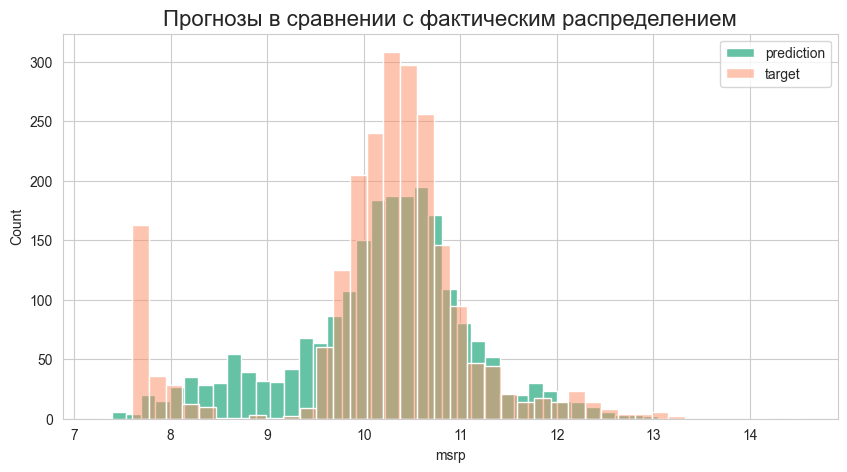

In [108]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(y_pred, bins=40, label='prediction', alpha=1)
sns.histplot(y_val, bins=40, label='target', alpha=0.5)
ax.set_title('Прогнозы в сравнении с фактическим распределением',fontsize=16)
plt.legend()
plt.show()

In [109]:
y_val = np.expm1(y_val.values)
y_pred = np.expm1(y_pred)

print(f'MAPE: {round(mean_absolute_percentage_error(y_val, y_pred)*100)}%')

MAPE: 37%


In [110]:
# Оценка каечства на тестовых данных
#X_test = data_test
X_test = prepare_x(data_test)

# предсказываем цену
y_pred = model.predict(X_test)

# проверяем качество
y_test = np.expm1(y_test.values)
y_pred = np.expm1(y_pred)

print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred)*100)}%')

MAPE: 37%


Данная модель ошибается в среднем на 37%(34%), требуется доработка.

### Использование модели

In [111]:
ad = {'make': 'toyota',
    'model': 'venza',
    'year': 2013,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'engine_cylinders': 6.0,
    'transmission_type': 'automatic',
    'driven_wheels': 'all_wheel_drive',
    'number_of_doors': 4.0 ,
    'market_category': 'crossover,performance',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'highway_mpg': 25,
    'city_mpg': 18,
    'popularity': 2031
}

In [113]:
# прееводим словарь в датафрейм и преобразовываем
df_test = pd.DataFrame([ad])

#X_test = df_test
X_test = prepare_x(df_test)

# предсказываем
y_pred = model.predict(X_test)

# берем экспоненту
np.expm1(y_pred)

array([28807.62913218])

Фактическая цена согласно источнику была 31120 долларов, наша модель неплохо спарвилась с конкретно этой задачей